In [1]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt


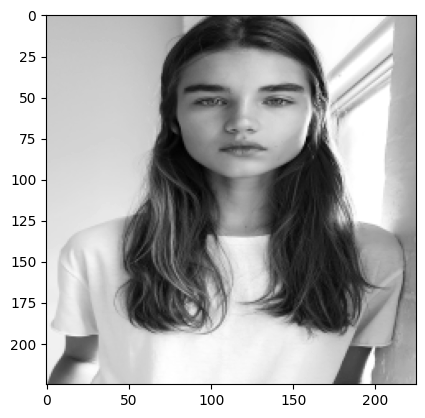

(225, 225)

In [2]:
img = cv2.imread('model1.jpg', cv2.IMREAD_GRAYSCALE)/255
img = cv2.resize(img, (225,225), interpolation = cv2.INTER_AREA)
plt.imshow(img, cmap ='gray')
plt.show()
img.shape

In [3]:
class Conv_op:
    def __init__(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.conv_filter = np.random.randn(num_filters,filter_size,filter_size)/(filter_size*filter_size)
        
    def image_region(self,image):
        height, width = image.shape
        self.image = image
        for j in range(height - self.filter_size +1):
            for k in range(width - self.filter_size +1):
                image_patch = image[j:(j+self.filter_size), k:(k+self.filter_size)]
                yield image_patch,j,k
    
    def forward_prop(self,image):
        height, width = image.shape
        conv_out = np.zeros((height- self.filter_size+1, width- self.filter_size +1, self.num_filters))
        for image_patch, i,j in self.image_region(image):
            conv_out[i,j] = np.sum(image_patch * self.conv_filter, axis = (1,2))
        return conv_out
    
    def back_prop(self, dL_dout, lr):
        dL_dF_params = np.zeros(self.conv_filter.shape)
        for image_patch, i, j in self.image_region(self.image):
            for k in range(self.num_filters):
                dL_dF_params[k] += image_patch * dL_dout[i,j,k]
                
        # Filter params update
        self.conv_filter -= lr*dL_dF_params
        return dL_dF_params
                

In [4]:
conv = Conv_op(18,7)
print(conv.conv_filter[0])
out = conv.forward_prop(img)
out.shape

[[-0.01449914 -0.00700926  0.00177537 -0.00778687 -0.01230756 -0.00907909
  -0.00367939]
 [-0.02217699  0.04422365 -0.02563185 -0.04008603  0.0200346  -0.0236129
   0.01036571]
 [-0.00479672 -0.01923757 -0.04820424  0.01356216  0.00452638 -0.02238905
   0.03429748]
 [-0.02009534  0.0036906  -0.01804547  0.00424773  0.02848665 -0.01169746
  -0.01378268]
 [ 0.01591313  0.04603169  0.00530771 -0.04789812 -0.01773478  0.00660757
  -0.00347562]
 [-0.00442973  0.02469841  0.01867044 -0.01679258  0.01006442  0.01166304
   0.01326486]
 [-0.00813357 -0.02005069  0.00621661  0.03382118 -0.01286554  0.01433174
  -0.01212811]]


(219, 219, 18)

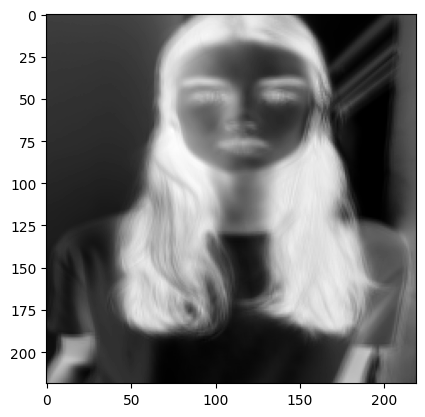

In [5]:
plt.imshow(out[:,:,17], cmap = 'gray')

In [6]:
class Max_Pool:
    def __init__(self,filter_size):
        self.filter_size = filter_size
        
    def image_region(self,image):
        new_height = image.shape[0]// self.filter_size
        new_width = image.shape[1] // self.filter_size
        self.image = image
        
        for i in range(new_height):
            for j in range(new_width):
                image_patch = image[(i*self.filter_size):(i*self.filter_size+ self.filter_size),(j*self.filter_size):(j*self.filter_size+ self.filter_size)]
                yield image_patch , i, j
            
    def forward_prop(self,image):
        height, width, num_filters = image.shape
        output = np.zeros((height // self.filter_size , width // self.filter_size , num_filters))
        
        for image_patch, i, j in self.image_region(image):
            output[i,j] = np.amax(image_patch, axis = (0,1))
            
        return output
    
    def back_prop(self, dL_dout):
        dL_dmax_pool = np.zeros(self.image.shape)
        for image_patch, i, j in self.image_region(self.image):
            height , width , num_filters = image_patch.shape
            maximum_val = np.amax(image_patch,axis = (0,1))
            
            for i1 in range(height):
                for j1 in range(width):
                    for k1 in range(num_filters):
                        if image_patch[i1,j1,k1] == maximum_val[k1]:
                            dL_dmax_pool[i*self.filter_size+ i1,j*self.filter_size+ j1, k1] = dL_dout[i,j,k1]
                            
            return dL_dmax_pool

In [7]:
conv2 = Max_Pool(4)
out2 = conv2.forward_prop(out)
out2.shape

(54, 54, 18)

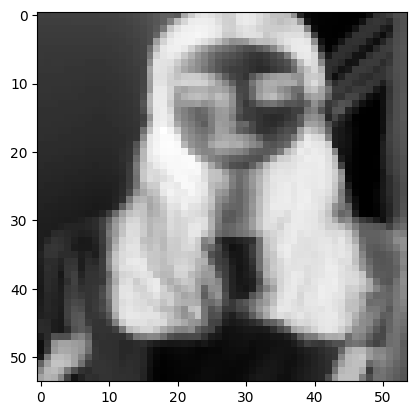

In [8]:
plt.imshow(out2[:,:,17], cmap = 'gray')
plt.show()

In [9]:
class Softmax:
    def __init__(self, input_node, softmax_node):
        self.weight = np.random.randn(input_node, softmax_node)/ input_node
        self.bias = np.zeros(softmax_node)
        
        
    def forward_prop(self, image):
        self.orig_im_shape = image.shape
        image_modified = image.flatten()
        self.modified_input = image_modified
        output_val = np.dot(image_modified, self.weight)+ self.bias
        self.out = output_val
        exp_out = np.exp(output_val)
        return exp_out/ np.sum(exp_out, axis = 0)
    
    def back_prop(self,dL_out, lr):
        for i, grad in enumerate(dL_out):
            if grad == 0:
                continue
            transformation_eq = np.exp(self.out)
            S_total = np.sum(transformation_eq)
            
            dy_dz = -transformation_eq[i] * transformation_eq/ (S_total **2)
            dy_dz[i] = transformation_eq[i] * (S_total -transformation_eq[i])/ (S_total **2)
        
            dz_dw = self.modified_input
            dz_db = 1
            dz_dinp = self.weight
            
            dL_dz = grad* dy_dz
            
            dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
            dL_db = dL_dz * dz_db
            dL_dinp = dz_dinp @ dL_dz
            
        self.weight -= lr* dL_dw
        self.bias -= lr *dL_db
        
        return dL_dinp.reshape(self.orig_im_shape)

In [10]:
conv3 = Softmax(54*54*18, 10)
out3 = conv3.forward_prop(out2)
out3

array([0.10004567, 0.09995708, 0.10000604, 0.09998747, 0.09999305,
       0.10000968, 0.10000773, 0.09999383, 0.10002051, 0.09997894])

In [11]:
from keras.datasets import mnist
(X_train,y_train), (X_test, y_test) = mnist.load_data()

2023-05-12 16:15:57.494512: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-12 16:15:57.626632: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-12 16:15:57.627571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 16:15:58.566096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
train_images = X_train[:1000]
train_labels = y_train[:1000]
test_images = X_test[:1000]
test_labels = y_test[:1000]



In [13]:
conv = Conv_op(8,3)
pool = Max_Pool(2)
softmax = Softmax(13*13*8,10)


In [14]:
def cnn_forward_prop(image,label):
    out_p = conv.forward_prop((image/255)-0.5)
    out_p = pool.forward_prop(out_p)
    out_p = softmax.forward_prop(out_p)
    
    cross_entropy_loss = -np.log(out_p[label])
    accuracy_eval = 1 if np.argmax(out_p) == label else 0
    
    return out_p, cross_entropy_loss , accuracy_eval


In [15]:
def train(image,label, lr = 0.05):
    
    #Forward propagation
    out, loss,acc = cnn_forward_prop(image,label)
    
    gradient = np.zeros(10)
    gradient[label] = -1 / out[label]
    
    #Backprop
    grad_back = softmax.back_prop(gradient,lr)
    grad_back = pool.back_prop(grad_back)
    grad_back = conv.back_prop(grad_back,lr)
    
    return loss, acc

In [19]:
for epoch in range(5):
    print('Epoch %d ---->' %(epoch +1))
    
    shuffle_data = np.random.permutation(len(train_images))
    train_images = train_images[shuffle_data]
    train_labels = train_labels[shuffle_data]
    
    loss = 0
    num_correct = 0
    for i , (im,label) in enumerate(zip(train_images, train_labels)):
        if i%100 == 0:
            print(f'{ i+1} steps out of 100 steps: Average Loss {loss/100} and accuracy {num_correct}')
            loss = 0
            num_correct = 0
            
        l1, accuracy = train(im,label)
        loss +=l1
        num_correct +=accuracy
        
        

Epoch 1 ---->
1 steps out of 100 steps: Average Loss 0.0 and accuracy 0
101 steps out of 100 steps: Average Loss 1.6216153369992592 and accuracy 69
201 steps out of 100 steps: Average Loss 1.3606638050409092 and accuracy 78
301 steps out of 100 steps: Average Loss 1.3612695437715485 and accuracy 71
401 steps out of 100 steps: Average Loss 1.1462235266412808 and accuracy 85
501 steps out of 100 steps: Average Loss 1.2080305959881408 and accuracy 80
601 steps out of 100 steps: Average Loss 1.1322639125603902 and accuracy 80
701 steps out of 100 steps: Average Loss 1.0056507574023343 and accuracy 81
801 steps out of 100 steps: Average Loss 0.9762487353017909 and accuracy 79
901 steps out of 100 steps: Average Loss 0.9993334452103088 and accuracy 77
Epoch 2 ---->
1 steps out of 100 steps: Average Loss 0.0 and accuracy 0
101 steps out of 100 steps: Average Loss 0.808393254809571 and accuracy 88
201 steps out of 100 steps: Average Loss 0.8363704196723785 and accuracy 86
301 steps out of 100 

In [20]:
print('**testing')
loss = 0
num_correct = 0
for im, label in zip(test_images,test_labels):
    _, l1,accuracy = cnn_forward_prop(im, label)
    loss +=1
    num_correct +=accuracy
    
num_tests = len(test_images)
print('Test Loss:',loss/num_tests)
print('Test Accuracy: ', num_correct/ num_tests)

**testing
Test Loss: 1.0
Test Accuracy:  0.821
